In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

In [2]:
df = pd.read_excel("C:/Users/webde/Downloads/taxcanada.xlsx",
                  names=['year','pop_millions','gdp_millions','longevity','poverty','govt_revenue_millions'])
df['mean_taxRate'] = np.round(df['govt_revenue_millions']/ df['gdp_millions'],3)
print("DF Columns:", df.columns)
print(df.shape)

DF Columns: Index(['year', 'pop_millions', 'gdp_millions', 'longevity', 'poverty',
       'govt_revenue_millions', 'mean_taxRate'],
      dtype='object')
(66, 7)


In [3]:
reindexed_df = df.copy()
reindexed_df.head()


,year,pop_millions,gdp_millions,longevity,poverty,govt_revenue_millions,mean_taxRate
0,1960,17.98,40265,71.1,0.145,11232,0.279
1,1961,18.27,42026,71.2,0.143,11522,0.274
2,1962,18.61,45739,71.4,0.140,12569,0.275
3,1963,18.96,49273,71.4,0.141,13464,0.273
4,1964,19.33,53975,71.8,0.138,15287,0.283


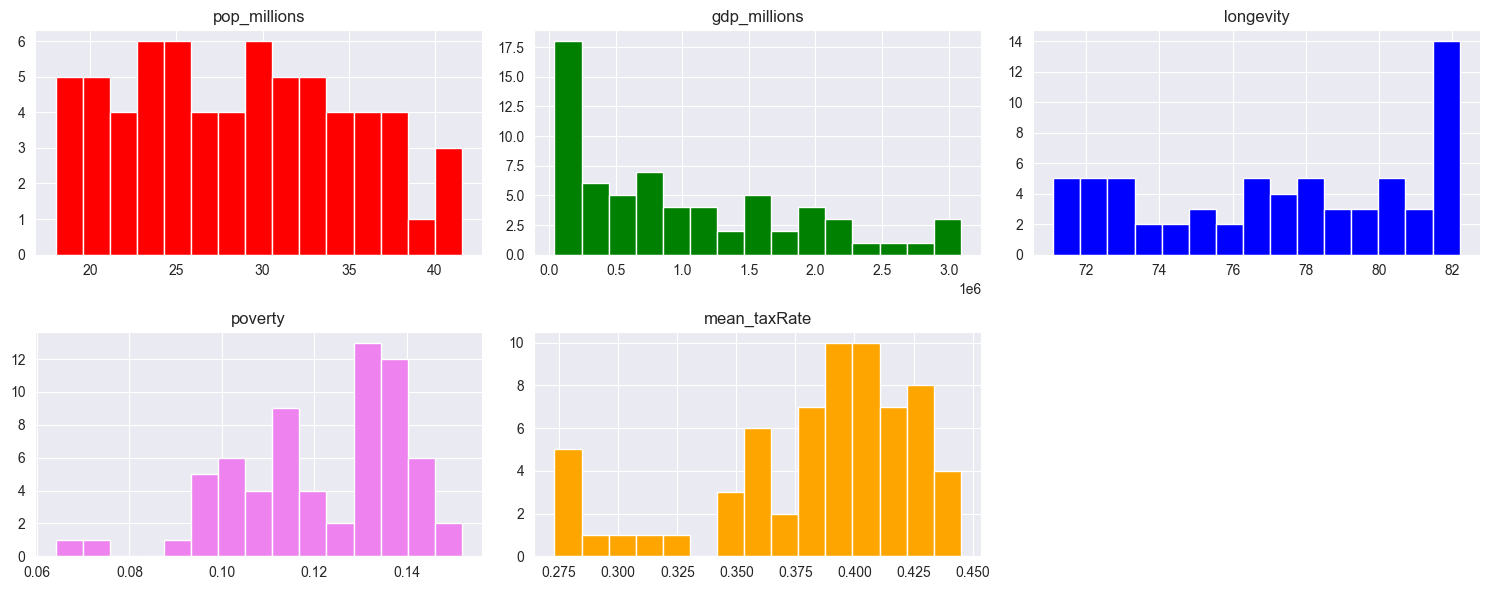

In [4]:
numeric_cols = reindexed_df[['pop_millions','gdp_millions','longevity','poverty','mean_taxRate']]
colors = ['red','green','blue','violet','orange']
axes_grid = numeric_cols.hist(figsize=(15,6),layout=(2,3),sharex=False, bins=15,legend=False)
for i, histogram_ax in enumerate(axes_grid.flat):
  if i < len(colors) and len(histogram_ax.patches)>0:
    for bar in histogram_ax.patches:
      bar.set_facecolor(colors[i])
plt.tight_layout()
plt.show()

In [5]:
import statsmodels.formula.api as smf
formula = 'gdp_millions~pop_millions+longevity+mean_taxRate'
reg = smf.ols(formula, data=numeric_cols).fit()
print('Regression Results:')
display(reg.summary())

Regression Results:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gdp_millions   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2682.
Date:                Sat, 24 Jan 2026   Prob (F-statistic):           1.56e-65
Time:                        16:56:33   Log-Likelihood:                -835.89
No. Observations:                  66   AIC:                             1680.
Df Residuals:                      62   BIC:                             1689.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.532e+06   7.48e+05      6.055      0.000    3.04e+06    6.03e+06
pop_millions  2.168e+05   6768.522     32.029      0.000    2.03e+05     2.3e+05
longevity    -1.016e+05   1.25e+04     -8.123      0.000   -1.27e+05   -7.66e+04
mean_taxRate -4.919e+06    3.5e+05    -14.034      0.000   -5.62e+06   -4.22e+06
==============================================================================
Omnibus:                        1.961   Durbin-Watson:                   0.790
Prob(Omnibus):                  0.375   Jarque-Bera (JB):                1.240
Skew:                           0.279   Prob(JB):                        0.538
Kurtosis:                       3.375   Cond. No.                     6.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name, maxlag=None):
    result = adfuller(series.dropna(), maxlag=2)
    return{
		'Variables': name,
  'ADF Statistic': result[0],
  'P-Value': result[1],
  'Lags Used': result[2],
  'Observations': result[3],
  # all critical values are inside result[4]
  'Critical 1%': result[4]['1%'],
  'Critical 5%': result[4]['5%'],
  'Critical 10%': result[4]['10%'],
  'Stationary': 'Yes' if result[1] < 0.05 else 'No'
	}
variables_to_test = ['gdp_millions','pop_millions','longevity','mean_taxRate']
adf_results = [adf_test(numeric_cols[var], var) for var in variables_to_test]
adf_df = pd.DataFrame(adf_results)

print("Augmented Dickey Fuller Test for Stationarity', fontsize=18,fontweight='bols'")
print("\nHo: Series has a unit root(non-stationary)")
print("H1: Series is Stationary")
# Display results
print(adf_df[['Variables', 'ADF Statistic','P-Value','Lags Used','Stationary']])
print('--'*60)
print("Critical Value Reference:")
print(adf_df[['Variables','Critical 1%','Critical 5%','Critical 10%']].to_string(index=False))
print("\nInterpretation: if ADF Statistic < Critical Value -> reject Ho -> stationary ")

Augmented Dickey Fuller Test for Stationarity', fontsize=18,fontweight='bols'

Ho: Series has a unit root(non-stationary)
H1: Series is Stationary
      Variables  ADF Statistic   P-Value  Lags Used Stationary
0  gdp_millions       4.455186  1.000000          2         No
1  pop_millions       2.243154  0.998916          2         No
2     longevity      -1.882755  0.340217          0         No
3  mean_taxRate      -1.944898  0.311243          0         No
------------------------------------------------------------------------------------------------------------------------
Critical Value Reference:
   Variables  Critical 1%  Critical 5%  Critical 10%
gdp_millions    -3.538695    -2.908645     -2.591897
pop_millions    -3.538695    -2.908645     -2.591897
   longevity    -3.535217    -2.907154     -2.591103
mean_taxRate    -3.535217    -2.907154     -2.591103

Interpretation: if ADF Statistic < Critical Value -> reject Ho -> stationary 


In [7]:
diff_df = numeric_cols.copy()
diff_df['d_gdp_millions'] = diff_df['gdp_millions'].diff()
diff_df['d_longevity'] = diff_df['longevity'].diff()
diff_df['d_pop_millions'] = diff_df['pop_millions'].diff()
diff_df['d_mean_taxRate'] = diff_df['mean_taxRate'].diff()

clean_diff_df = diff_df.dropna()
# run the difference regression
diff_formula = 'd_gdp_millions~d_pop_millions+d_longevity+d_mean_taxRate'
diff_reg = smf.ols(diff_formula, data=clean_diff_df).fit()
print(" ======= Regression Results (Diff Model) ========")
display(diff_reg.summary())

 ======= Regression Results (Diff Model) ========


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         d_gdp_millions   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     3.913
Date:                Sat, 24 Jan 2026   Prob (F-statistic):             0.0127
Time:                        16:56:33   Log-Likelihood:                -807.20
No. Observations:                  65   AIC:                             1622.
Df Residuals:                      61   BIC:                             1631.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.746e+04   1.99e+04      0.878      0.383   -2.23e+04    5.72e+04
d_pop_millions  9.726e+04   4.51e+04      2.158      0.035    7121.300    1.87e+05
d_longevity    -1683.1423   4.43e+04     -0.038      0.970   -9.03e+04     8.7e+04
d_mean_taxRate -2.176e+06   8.24e+05     -2.642      0.010   -3.82e+06   -5.29e+05
==============================================================================
Omnibus:                       37.221   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.316
Skew:                           1.367   Prob(JB):                     3.53e-46
Kurtosis:                      11.355   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
def adf_test(series, name, maxlag=None):
    result = adfuller(series.dropna(), maxlag=2)
    return{
		'Variables': name,
  'ADF Statistic': result[0],
  'P-Value': result[1],
  'Lags Used': result[2],
  'Observations': result[3],
  # all critical values are inside result[4]
  'Critical 1%': result[4]['1%'],
  'Critical 5%': result[4]['5%'],
  'Critical 10%': result[4]['10%'],
  'Stationary': 'Yes' if result[1] < 0.05 else 'No'
	}
variables_to_test = ['d_gdp_millions','d_pop_millions','d_longevity','d_mean_taxRate']
adf_results = [adf_test(clean_diff_df[var], var) for var in variables_to_test]
adf_df = pd.DataFrame(adf_results)

print("Augmented Dickey Fuller Test for Stationarity")
print("\nHo: Series has a unit root(non-stationary)")
print("H1: Series is Stationary")
# Display results
print(adf_df[['Variables', 'ADF Statistic','P-Value','Lags Used','Stationary']])
print('--'*60)
print("Critical Value Reference:")
print(adf_df[['Variables','Critical 1%','Critical 5%','Critical 10%']].to_string(index=False))
print("\nInterpretation: if ADF Statistic < Critical Value -> reject Ho -> stationary ")

Augmented Dickey Fuller Test for Stationarity

Ho: Series has a unit root(non-stationary)
H1: Series is Stationary
        Variables  ADF Statistic       P-Value  Lags Used Stationary
0  d_gdp_millions      -6.790199  2.375405e-09          0        Yes
1  d_pop_millions      -5.593452  1.313145e-06          1        Yes
2     d_longevity      -3.156072  2.267243e-02          2        Yes
3  d_mean_taxRate      -7.296486  1.373674e-10          0        Yes
------------------------------------------------------------------------------------------------------------------------
Critical Value Reference:
     Variables  Critical 1%  Critical 5%  Critical 10%
d_gdp_millions    -3.536928    -2.907887     -2.591493
d_pop_millions    -3.538695    -2.908645     -2.591897
   d_longevity    -3.540523    -2.909427     -2.592314
d_mean_taxRate    -3.536928    -2.907887     -2.591493

Interpretation: if ADF Statistic < Critical Value -> reject Ho -> stationary 
